# Time series forecast predictions

In [3]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style

from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
train1 = pd.read_csv("/kaggle/input/train1/train_1.csv", parse_dates=True)
train2 = pd.read_csv("/kaggle/input/train1/train_2.csv", parse_dates=True)

## Statistical tests

### Augmented Dickey-Fuller test

* This test checks if the data is stationary or not.
* It is a hypothesis testing in which the null hypothesis is that the data is non-stationary.
- **p-value > 0.05**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- **p-value <= 0.05**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [3]:
name = []
for page in train1['Page']:
    split = page.split('.')
    name.append(split[-3])

train1['Name'] = name
train1['Language'] = train1['Name'].str[-2:]

In [9]:
from statsmodels.tsa.stattools import adfuller

def stationarity_test(timeseries, rolling_window, language):
    plt.figure(figsize=(50, 8))
    
    rolling_mean = pd.DataFrame.rolling(timeseries, window=rolling_window).mean()
    rolling_std = pd.DataFrame.rolling(timeseries, window=rolling_window).std()

    plt.plot(timeseries, color='blue', label= 'Original')
    plt.legend(loc='best')
    
    plt.plot(rolling_mean, color='red', label= 'Rolling Mean')
    plt.legend(loc='best')
    std = plt.plot(rolling_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    
    plt.title(f'Rolling Mean & Standard Deviation by Language : {language}')
    plt.show()
    
    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test')
    print()
    test = adfuller(timeseries, autolag='AIC')
    output = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
        output['Critical Value (%s)'%key] = value
    print(output)
    print('-'*100)

# as the wikipedia pages have different languages we need to do the analysis for different languages seperately

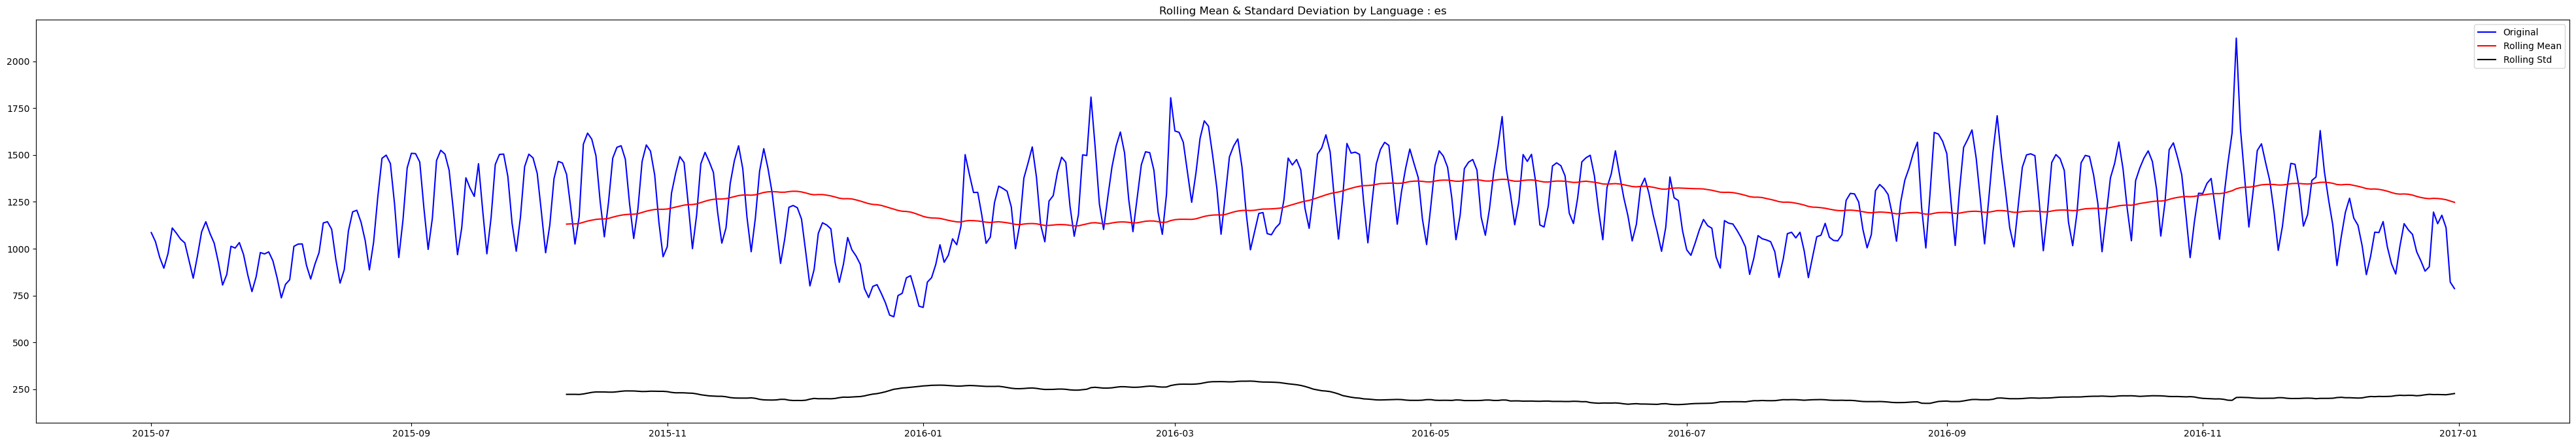

Results of Dickey-Fuller Test

Test Statistic                  -3.014209
p-value                          0.033589
#Lags Used                      15.000000
Number of Observations Used    534.000000
Critical Value (1%)             -3.442655
Critical Value (5%)             -2.866968
Critical Value (10%)            -2.569661
dtype: float64
----------------------------------------------------------------------------------------------------


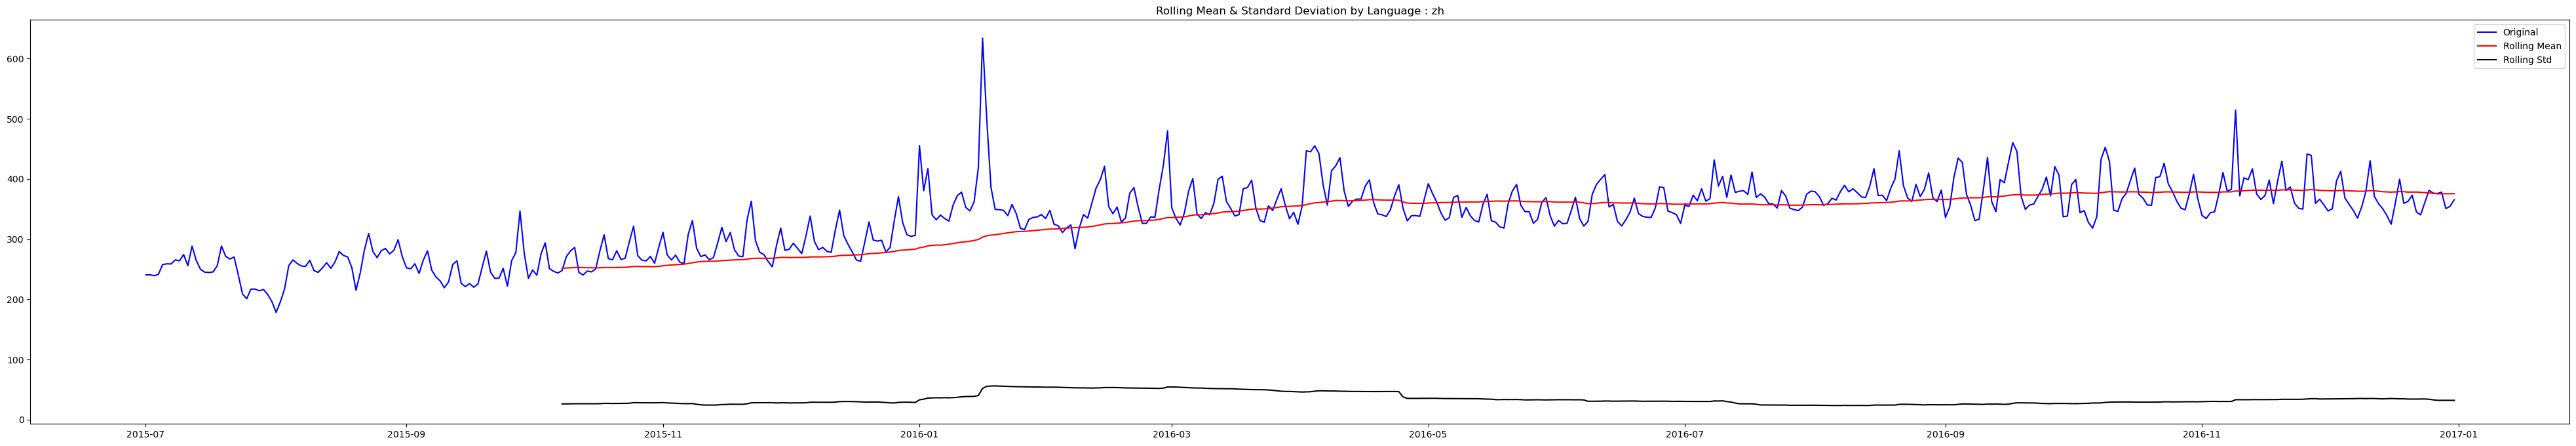

Results of Dickey-Fuller Test

Test Statistic                  -1.668433
p-value                          0.447446
#Lags Used                      19.000000
Number of Observations Used    530.000000
Critical Value (1%)             -3.442749
Critical Value (5%)             -2.867009
Critical Value (10%)            -2.569683
dtype: float64
----------------------------------------------------------------------------------------------------


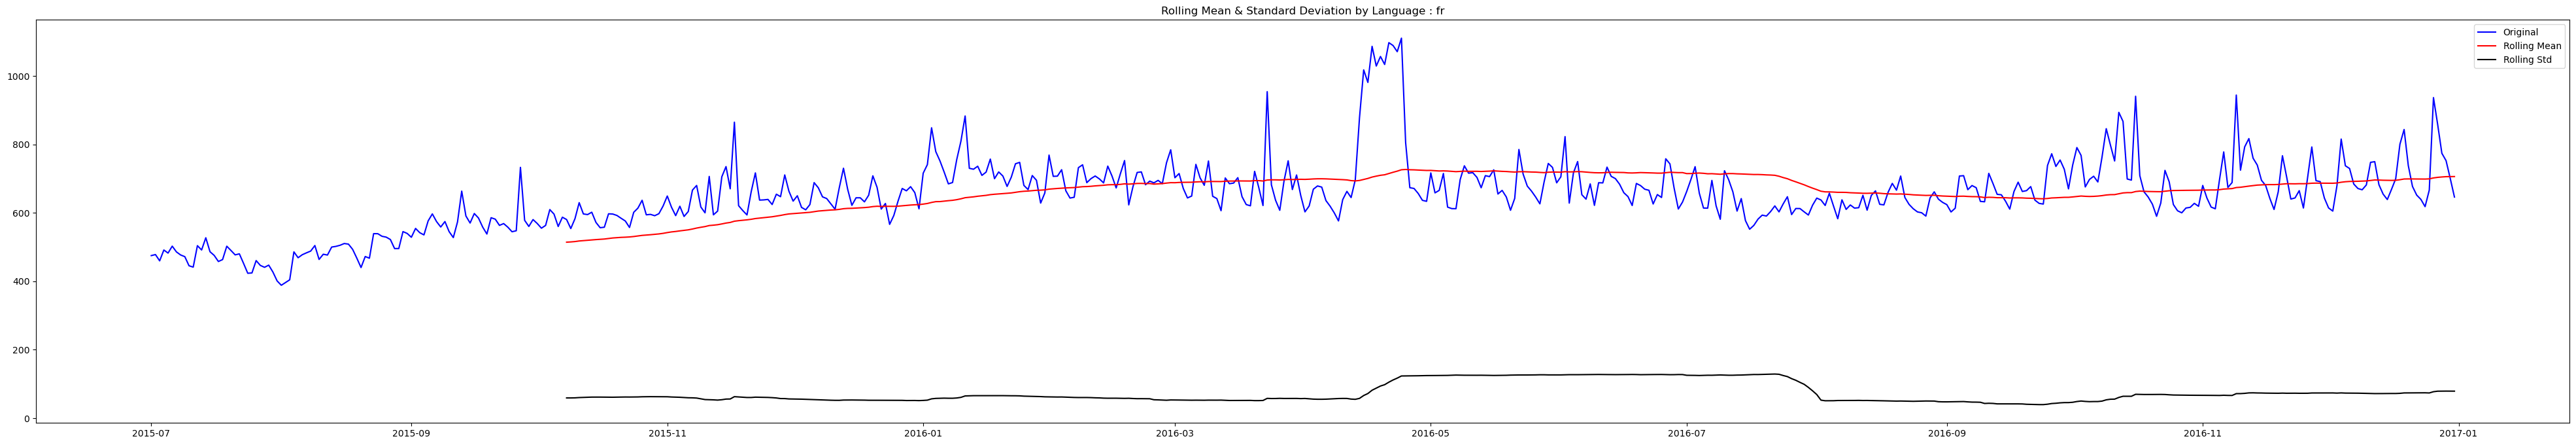

Results of Dickey-Fuller Test

Test Statistic                  -2.849875
p-value                          0.051495
#Lags Used                      13.000000
Number of Observations Used    536.000000
Critical Value (1%)             -3.442609
Critical Value (5%)             -2.866947
Critical Value (10%)            -2.569650
dtype: float64
----------------------------------------------------------------------------------------------------


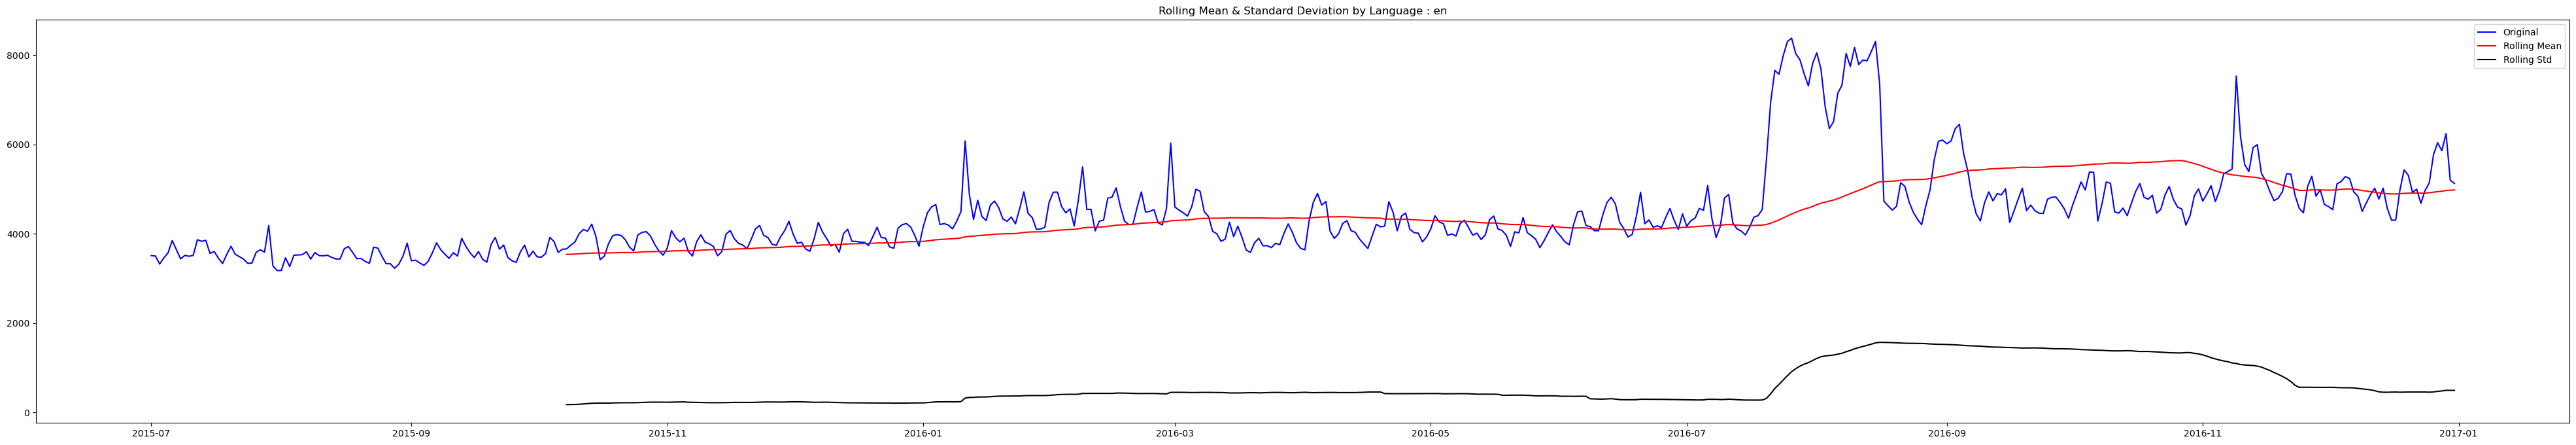

Results of Dickey-Fuller Test

Test Statistic                  -2.247284
p-value                          0.189534
#Lags Used                      14.000000
Number of Observations Used    535.000000
Critical Value (1%)             -3.442632
Critical Value (5%)             -2.866957
Critical Value (10%)            -2.569655
dtype: float64
----------------------------------------------------------------------------------------------------


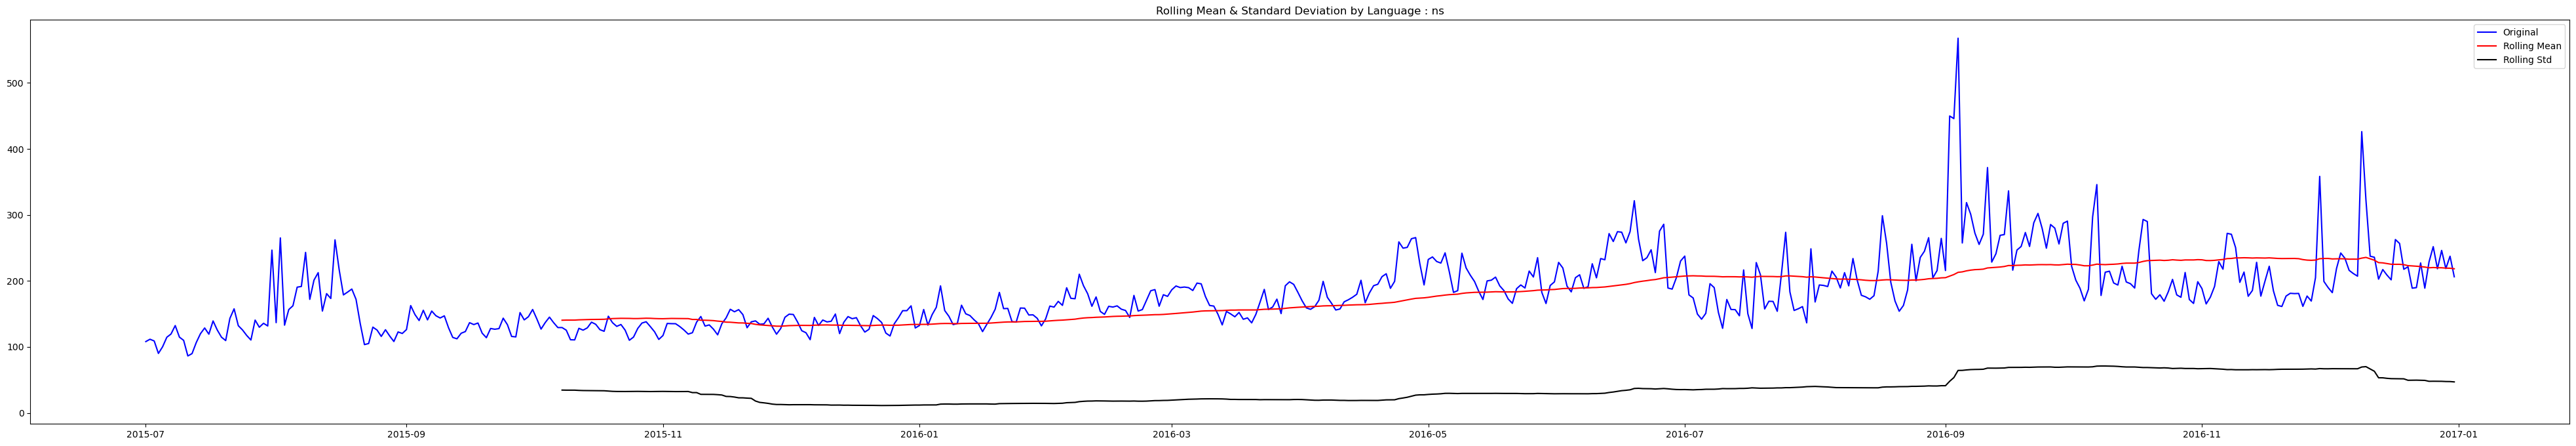

Results of Dickey-Fuller Test

Test Statistic                  -2.840219
p-value                          0.052754
#Lags Used                       6.000000
Number of Observations Used    543.000000
Critical Value (1%)             -3.442450
Critical Value (5%)             -2.866877
Critical Value (10%)            -2.569613
dtype: float64
----------------------------------------------------------------------------------------------------


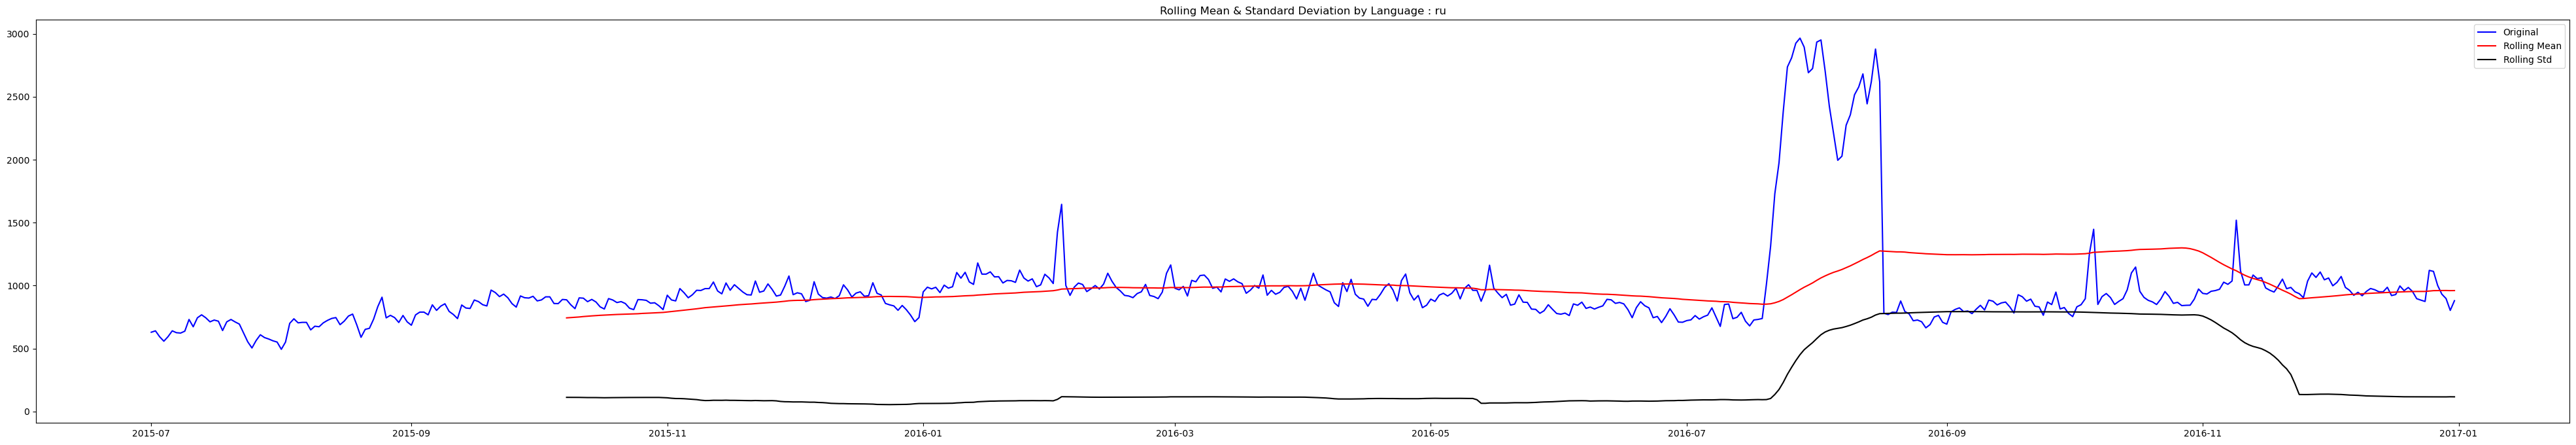

Results of Dickey-Fuller Test

Test Statistic                  -3.924031
p-value                          0.001865
#Lags Used                       3.000000
Number of Observations Used    546.000000
Critical Value (1%)             -3.442384
Critical Value (5%)             -2.866848
Critical Value (10%)            -2.569597
dtype: float64
----------------------------------------------------------------------------------------------------


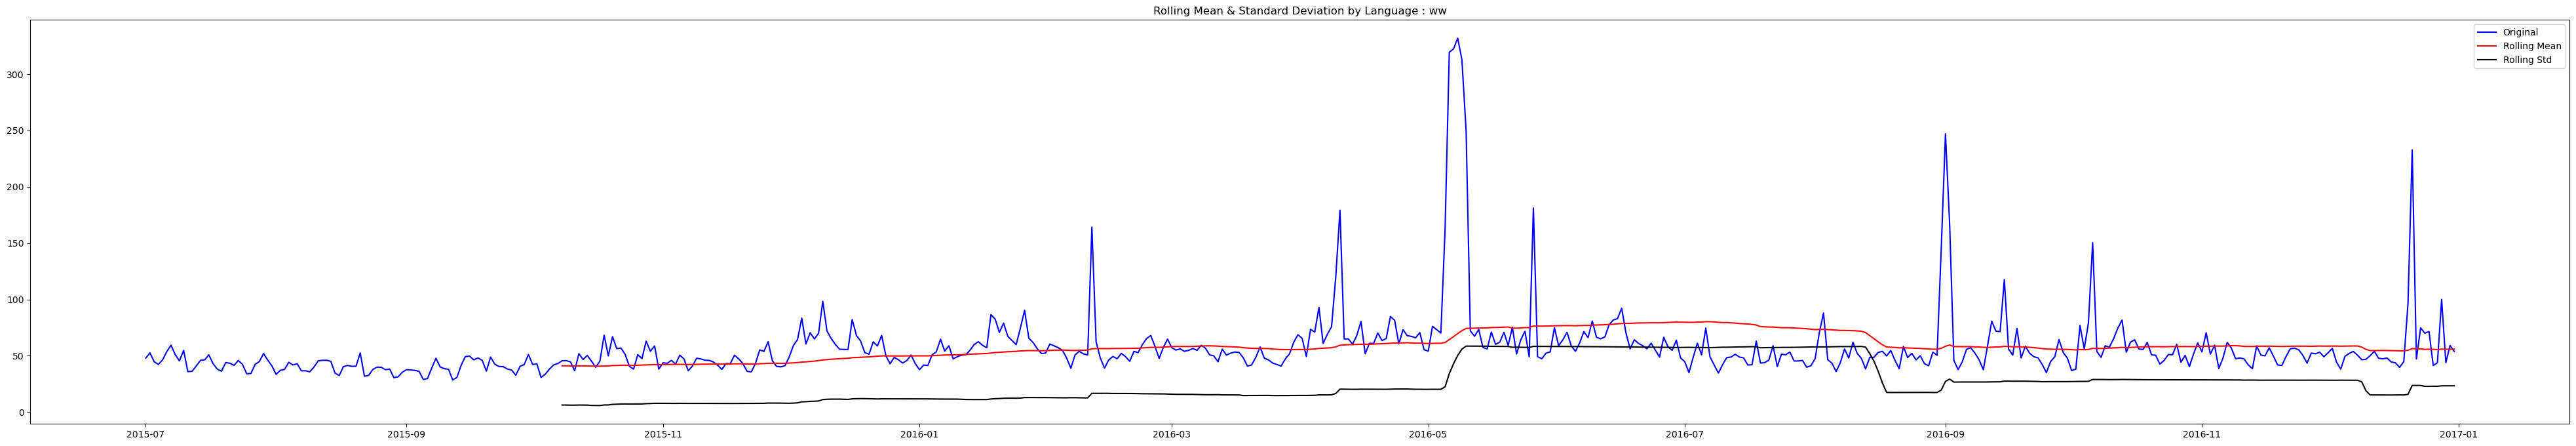

Results of Dickey-Fuller Test

Test Statistic                -6.338871e+00
p-value                        2.786556e-08
#Lags Used                     7.000000e+00
Number of Observations Used    5.420000e+02
Critical Value (1%)           -3.442473e+00
Critical Value (5%)           -2.866887e+00
Critical Value (10%)          -2.569618e+00
dtype: float64
----------------------------------------------------------------------------------------------------


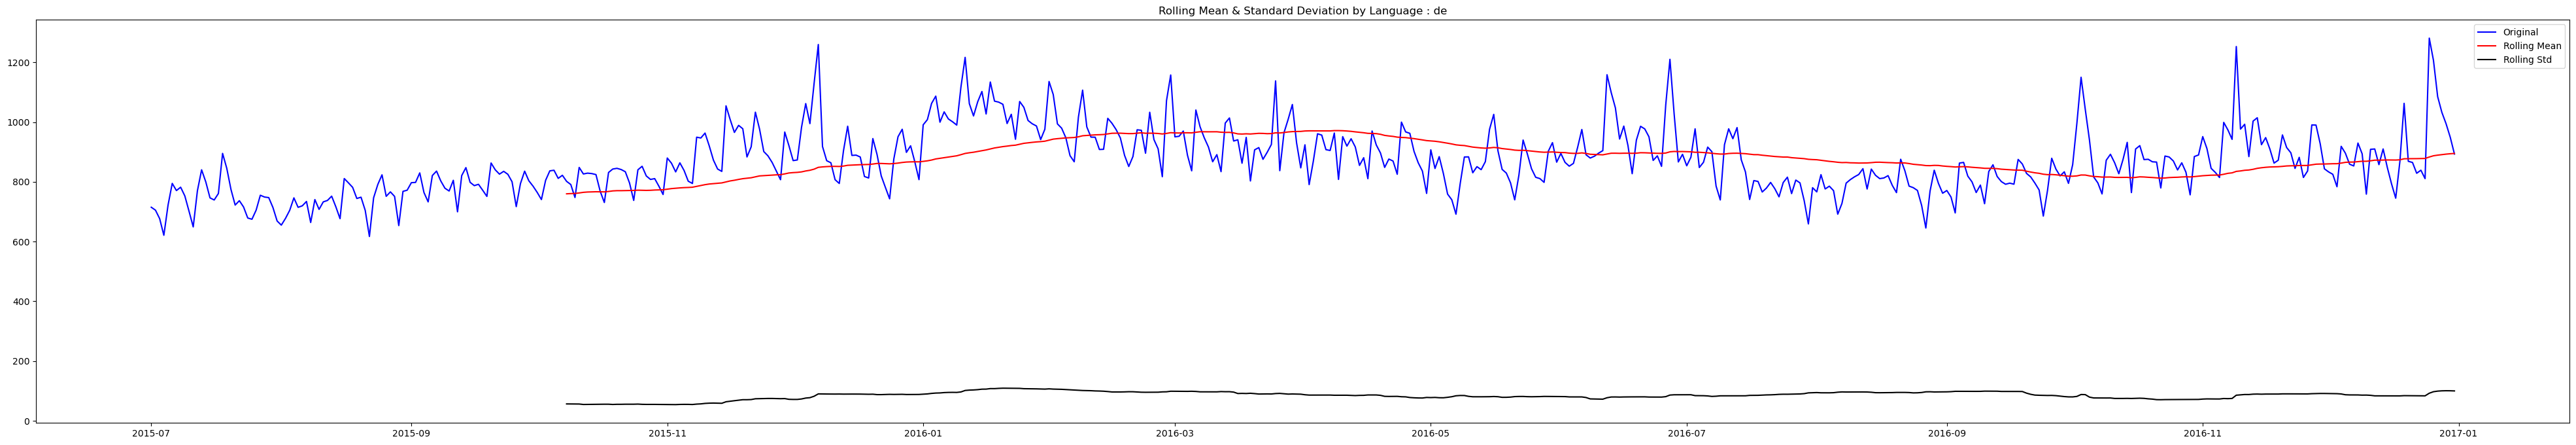

Results of Dickey-Fuller Test

Test Statistic                  -2.402707
p-value                          0.140974
#Lags Used                      16.000000
Number of Observations Used    533.000000
Critical Value (1%)             -3.442678
Critical Value (5%)             -2.866978
Critical Value (10%)            -2.569666
dtype: float64
----------------------------------------------------------------------------------------------------


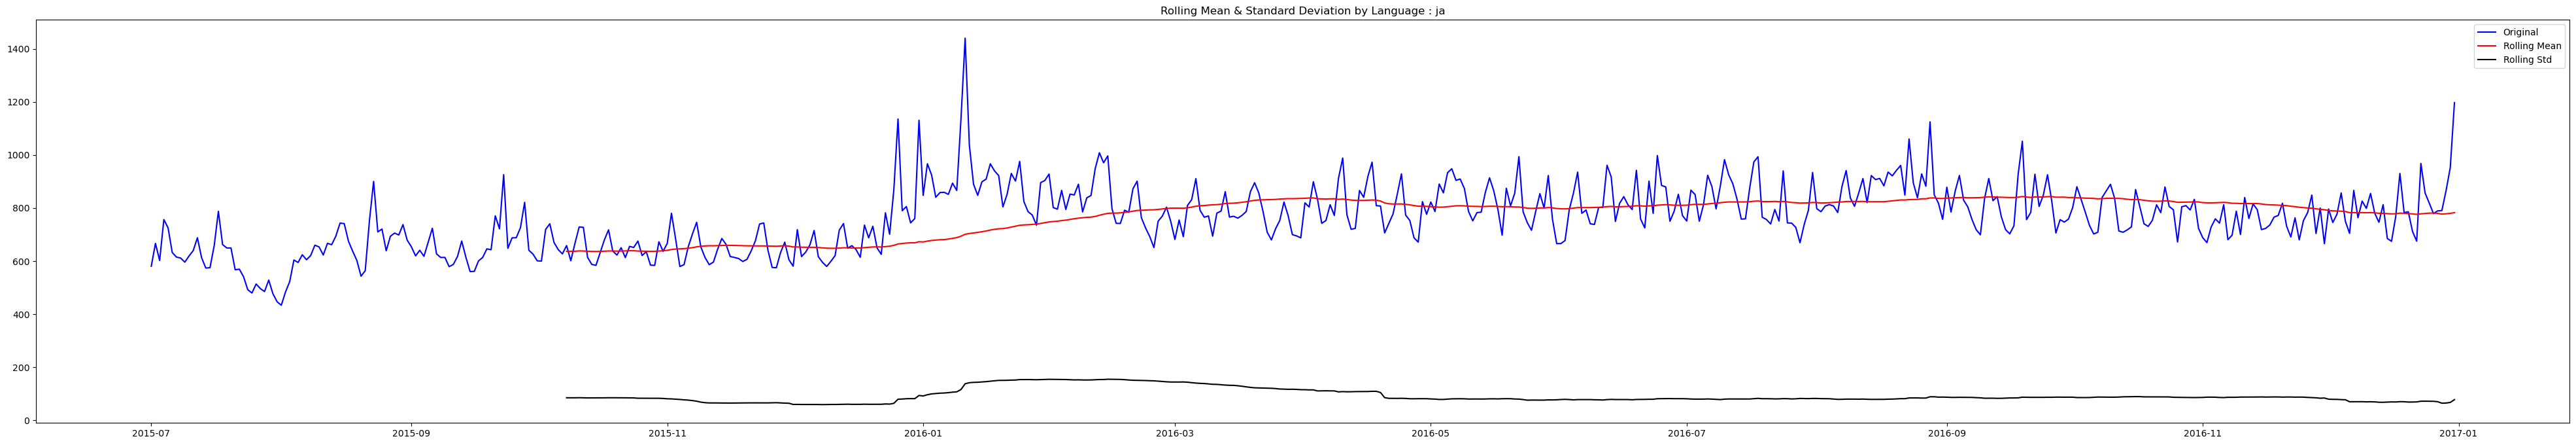

Results of Dickey-Fuller Test

Test Statistic                  -2.555394
p-value                          0.102571
#Lags Used                       8.000000
Number of Observations Used    541.000000
Critical Value (1%)             -3.442495
Critical Value (5%)             -2.866897
Critical Value (10%)            -2.569623
dtype: float64
----------------------------------------------------------------------------------------------------


In [10]:
languages = ['es', 'zh', 'fr', 'en', 'ns', 'ru', 'ww', 'de', 'ja']

for lang in languages:
    
    df = train1[train1['Language'] == lang]
    
    remove_col = ['Language', 'Name']
    pv = df.drop(remove_col, axis=1)
    
    pivot = pv.melt(id_vars='Page', var_name='Date', value_name='Visits')
    pivot['Date'] = pd.to_datetime(pivot['Date'])
    pivot.fillna(0, inplace=True)
    
    group_by = pivot[['Date', 'Visits', 'Page']].groupby(['Date'])['Visits'].mean()
    
    stationarity_test(group_by, rolling_window=100, language=lang)

* From the above graph we can conlude that the p-value of zh, en, ja is greater than 5% which means that the data is non-stationary, whereas the p-value for other languages is less than 5%, that means they are stationary.

## Auto Correlation and Partial Correlation

In [11]:
pivot = train1.drop(['Name', 'Language'], axis=1)
train_pivot = pivot.melt(id_vars='Page', var_name='Date', value_name='Visits')

In [12]:
train_pivot.head()

,Page,Date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,NaN


In [13]:
train_pivot.fillna(0, inplace=True)

In [14]:
train_pivot['Visits'] = train_pivot['Visits'].astype('float')

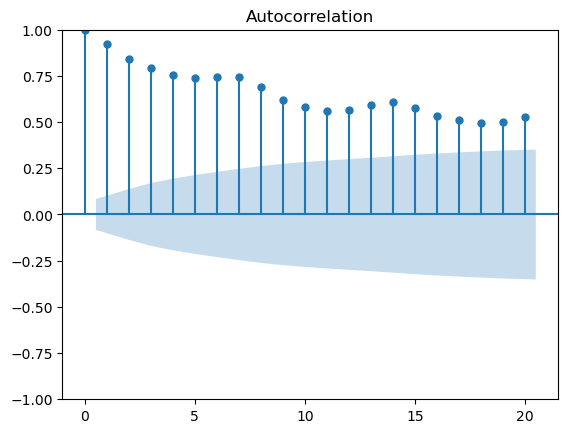

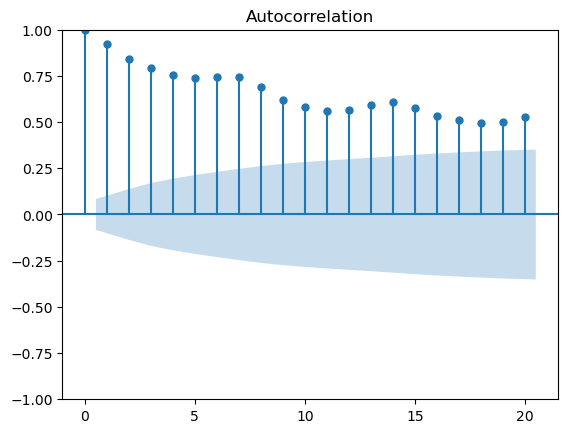

In [15]:
acf = train_pivot[['Date', 'Visits']].groupby(['Date'])['Visits'].mean()
plot_acf(acf, lags=20)

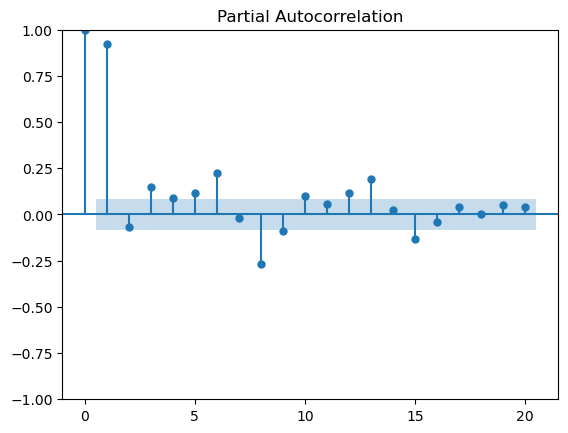

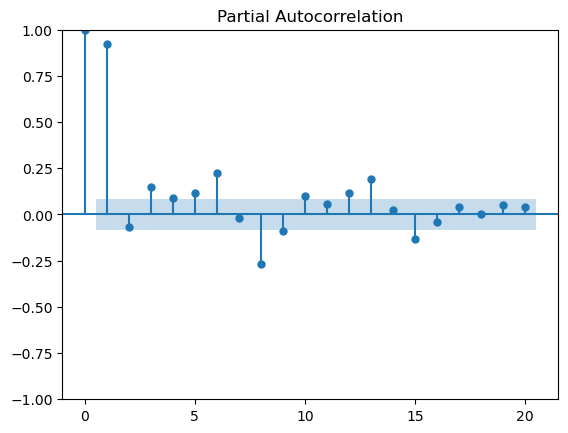

In [16]:
plot_pacf(acf, lags=20)

* We can see that there is geometric decrease in acf lags and sudden decrease in pacf after 2 lags

![AR and MA based on ACF and PACF](https://miro.medium.com/max/3000/1*MJIw0Lh2_PYMKJVTUVWAEw.png)

## Building and Testing Models

* From the above image we can see that we have geometric decrease in ACF and sudden decrease after 2 significant lags

In [17]:
# SMAPE Metric
def smape(actual, forecast):
    result = 1/len(actual) * np.sum(2*np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast))*100)
    return result

In [18]:
def plot_predictions(actual, predicted, figsize, title):
    
    plt.figure(figsize=figsize)
    actual = plt.plot(actual, color='blue', label='Actual')
    predicted = plt.plot(predicted, color='red', label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

In [19]:
data = train1.drop(['Page', 'Name', 'Language'], axis=1)
data.fillna(0, inplace=True)

### AR Model

In [20]:
from statsmodels.tsa.ar_model import AutoReg

In [21]:
def AutoRegression(data, lags, test_days, visualize_prediction:bool=False):
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))
    
    train = scaled_data[:-test_days]
    test = scaled_data[-test_days:]
    
    ar = AutoReg(train, lags=lags)
    model = ar.fit()
    
    # Predict
    ## Training predictions
    train_start = 0
    train_end = len(train)
    train_pred = model.predict(start=train_start, end=train_end)
    
    ## Testing predictions
    test_start = len(train)
    test_end = len(train) + len(test)
    test_pred = model.predict(start=test_start, end=test_end)
    
    ## Inverse transform
    train_inverse = scaler.inverse_transform(train_pred.reshape(-1, 1))
    test_inverse = scaler.inverse_transform(test_pred.reshape(-1, 1))
    
    # Plot predictions
    if visualize_prediction:
        plot_predictions(train, train_pred, figsize=(20, 6), title='AR Trainig (In Fold) Predictions')
        plot_predictions(test, test_pred, figsize=(20, 6), title='AR Testing (Out of Fold) Predictions')
    
    train_error = smape(train, train_pred)
    test_error = smape(test, test_pred)
    
    print(f'Train Error: {train_error} | Test Error: {test_error}')

    return model

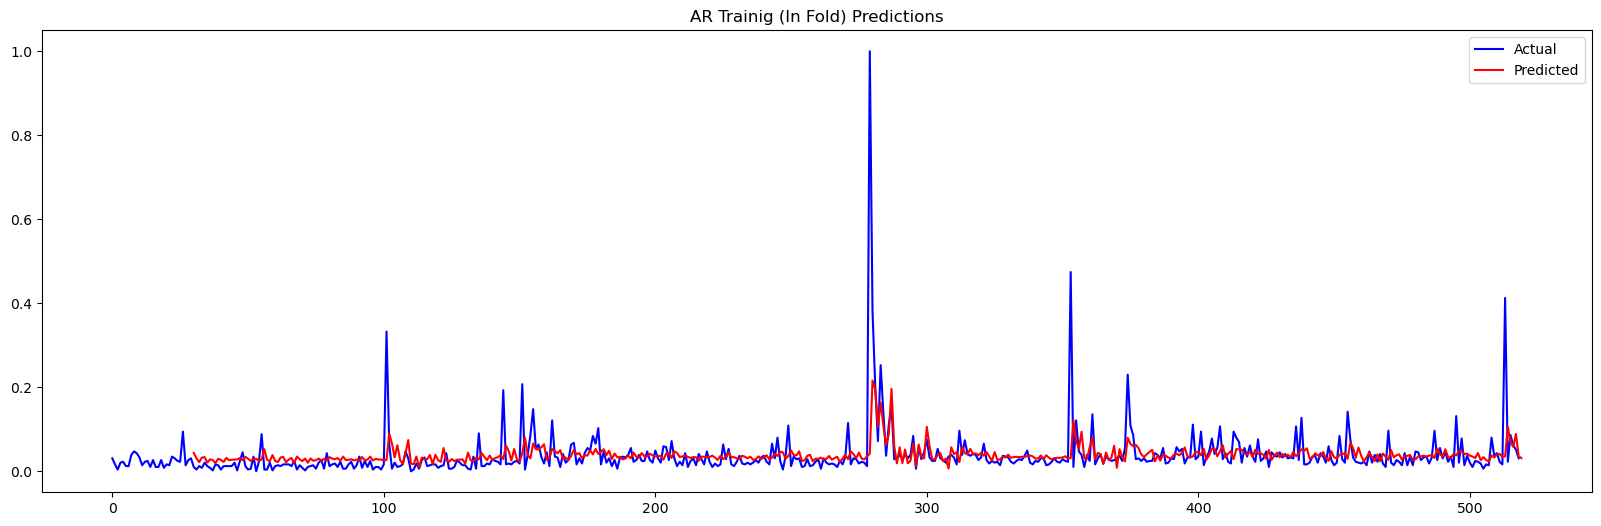

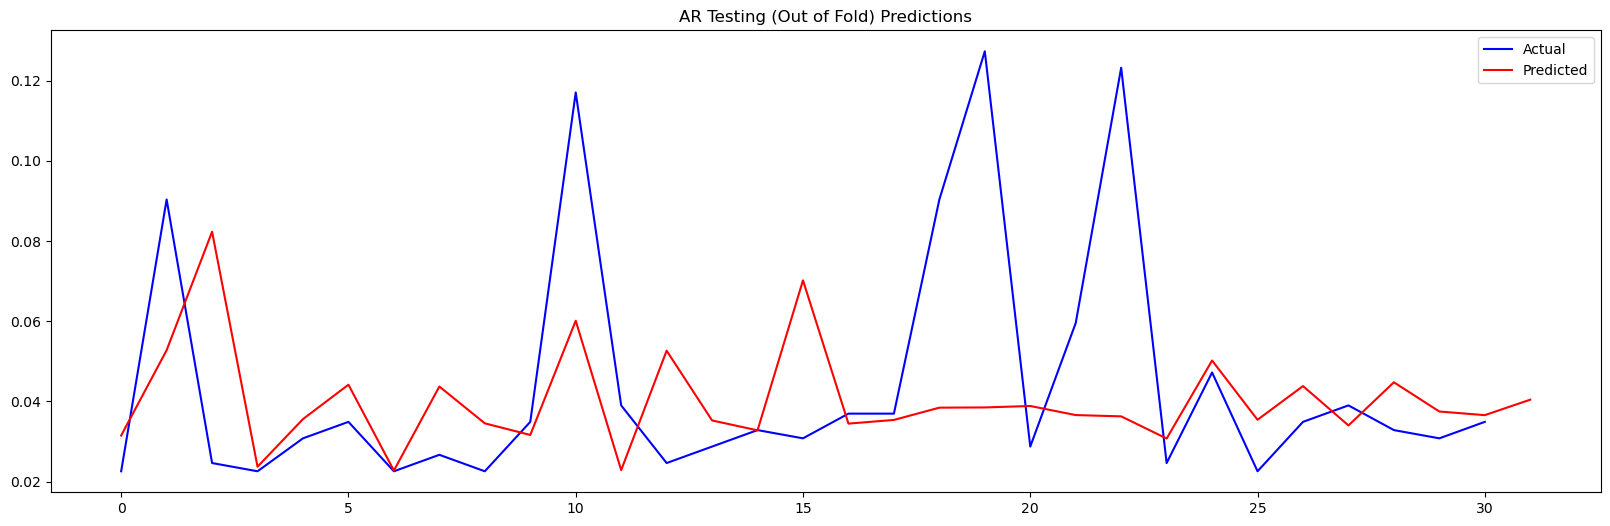

Train Error: nan | Test Error: 1367.1588631346135


In [22]:
train = data.iloc[0, :].values
model = AutoRegression(train, 30, 31, True)

### ARIMA

In [23]:
from statsmodels.tsa.arima.model import ARIMA

In [24]:
def Arima(data, p, d, q, test_days, visualize_predictions=False):

    train_date = data[:-31]
    test_date = data[-31:]

    data = data.astype('float')
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    #scaled_data.index = pd.to_datetime(data.index)
    train = scaled_data[:-31]
    test = scaled_data[-31:]

    #print(train), print(type(train)), print(train.shape), print(len(train))
    train = pd.Series(train.reshape(len(train)), index=pd.to_datetime(train_date.index))
    test = pd.Series(test.reshape(len(test)), index=pd.to_datetime(test_date.index))

    arima = ARIMA(train, order=[p, d, q])
    model = arima.fit()

    # Predict
    ## Training predictions
    train_start = 0
    train_end = len(train)
    train_pred = model.predict(start=train_start, end=train_end, typ='levels')

    ## Testing predictions
    test_start = len(train)
    test_end = len(train) + len(test) - 1
    test_pred = model.predict(start=test_start, end=test_end, typ='levels')

    # Inverse transform
    train_inverse = scaler.inverse_transform(np.array(train_pred).reshape(-1, 1))
    test_inverse = scaler.inverse_transform(np.array(test_pred).reshape(-1, 1))

    #print(test_pred)

    if visualize_predictions:
        plot_predictions(train, train_pred, (20, 5), 'ARIMA Training Predictions')
        plot_predictions(test, test_pred, (20, 5), 'ARIMA Testing Predictions')
    
    train_error = smape(train, train_pred)
    test_error = smape(test, test_pred)
    
    print(f'Train Error: {train_error} | Test Error: {test_error}')
    
    return model

In [25]:
row = data.iloc[0, :]

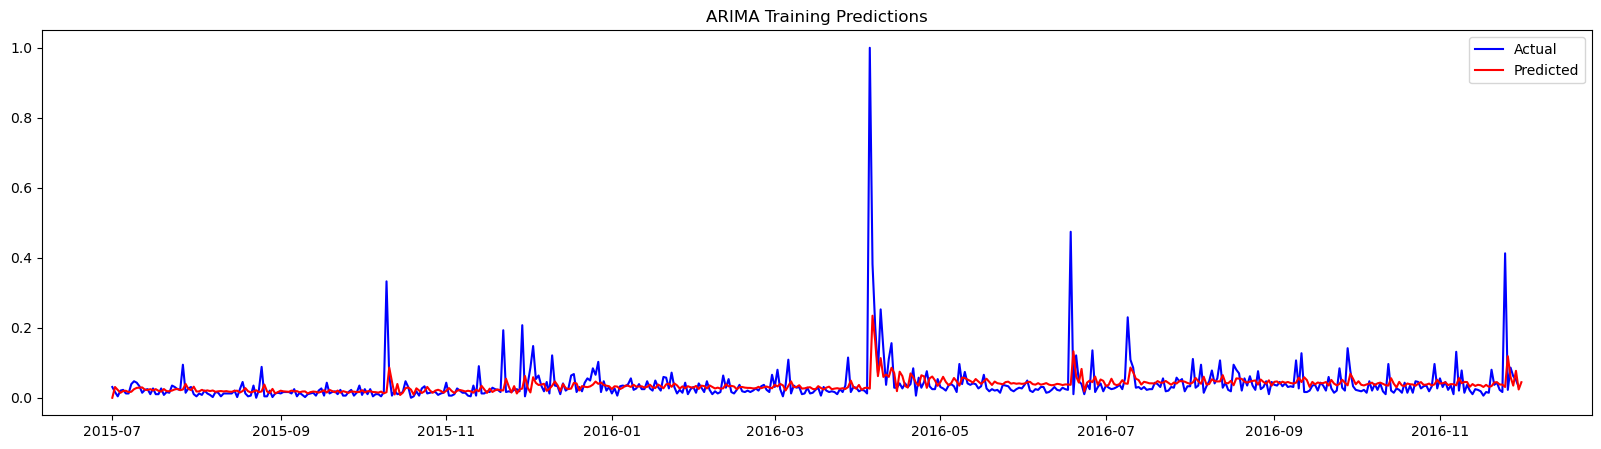

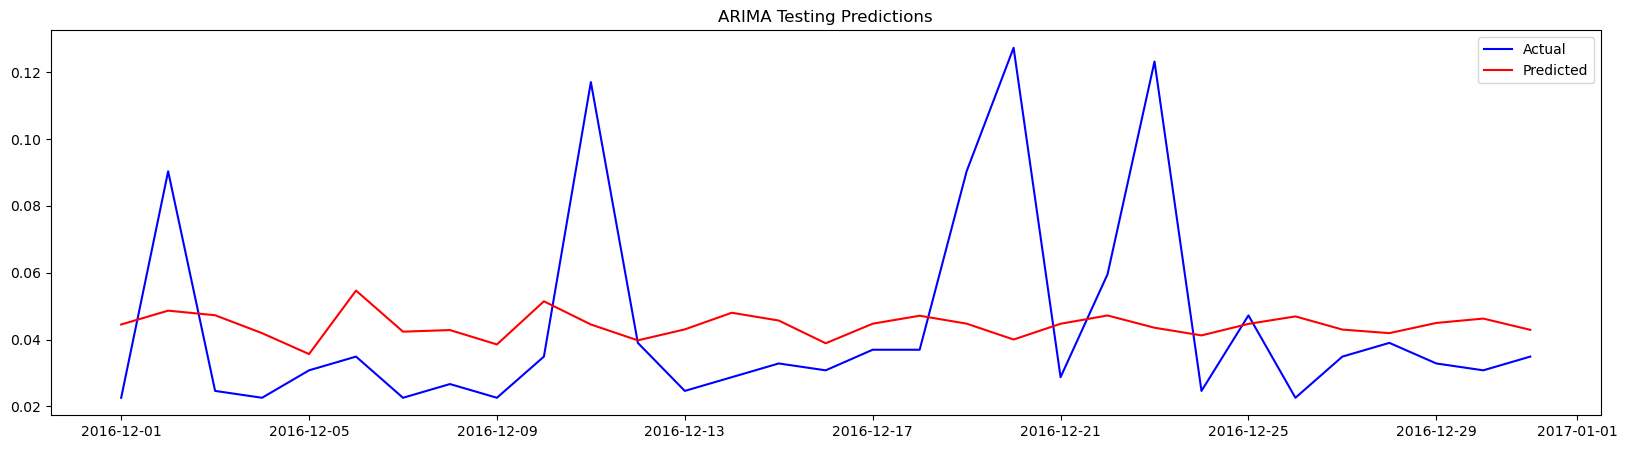

Train Error: 55.61936865606445 | Test Error: 44.52205538681887


In [26]:
model = Arima(row, 5, 1, 5, 31, visualize_predictions=True)

### Prophet

In [6]:
conda install libpython m2w64-toolchain -c msys2

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - m2w64-toolchain
  - libpython

Current channels:

  - https://conda.anaconda.org/msys2/linux-64
  - https://conda.anaconda.org/msys2/noarch
  - https://conda.anaconda.org/rapidsai/linux-64
  - https://conda.anaconda.org/rapidsai/noarch
  - https://conda.anaconda.org/nvidia/linux-64
  - https://conda.anaconda.org/nvidia/noarch
  - https://conda.anaconda.org/conda-forge/linux-64
  - https://conda.anaconda.org/conda-forge/noarch
  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anacond

In [7]:
!pip install pystan~=2.14
!pip install fbprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 MB 17.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=9434312 sha256=93a4c2afd4e4917bb63e0d55a83b21c9577f35597d2e1a939dcd029ea6daaf3c
  Stored in directory: /root/.cache/pip/wheels/fc/66/ad/951ba2b4576f7364afe7aeea8b0036e38d2179d6773f16d69f
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.1.0
    Uninstalling cmdstanpy-1.1.0:
      Successfully uninstalled cmdstanpy-1.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.1.1 requires cmdstanpy>=1.0.4, but you have cmdstanpy 0.9.5 which is incompatible.


In [27]:
from fbprophet import Prophet

In [28]:
def prophet(data, test_days, visualize_predictions, plot_prophet_comp:bool=False):
    
    train_date = data[:-test_days]
    test_date = data[-test_days:]
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
    
    train = scaled_data[:-test_days]
    test = scaled_data[-test_days:]
    
    df = pd.DataFrame({'ds':pd.to_datetime(train_date.index), 'y':train.reshape(len(train))})
    
    model = Prophet()
    model.fit(df)
    
    
    future = model.make_future_dataframe(periods=test_days)
    forecast = model.predict(future)
    
    train_actual = pd.Series(train.reshape(len(train)), index=pd.to_datetime(train_date.index))
    train_pred = pd.Series(forecast.yhat.values[:-test_days].reshape(len(train)), index=pd.to_datetime(train_date.index))
    
    test_actual = pd.Series(test.reshape(len(test)), index=pd.to_datetime(test_date.index))
    test_pred = pd.Series(forecast.yhat.values[-test_days:].reshape(len(test)), index=pd.to_datetime(test_date.index))
    
    # Visualize Predictions
    if visualize_predictions:
        plot_predictions(train_actual, train_pred, title='Prophet In Fold Predictions', figsize=(20, 5))
        plot_predictions(test_actual, test_pred, title='Prophet Out of Fold Predictions', figsize=(20, 5))
    
    if plot_prophet_comp:
        fig1 = model.plot(forecast)
        fig2 = model.plot_components(forecast)
    
    train_error = smape(train_actual, train_pred)
    test_error = smape(test_actual, test_pred)
    
    print(f'Train Error: {train_error} | Test Error: {test_error}')
    
    return model

Initial log joint probability = -2.99904
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1195.23   2.58329e-08       90.1452       0.481       0.481      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       1195.23   2.47251e-08       90.3698      0.1957           1      128   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


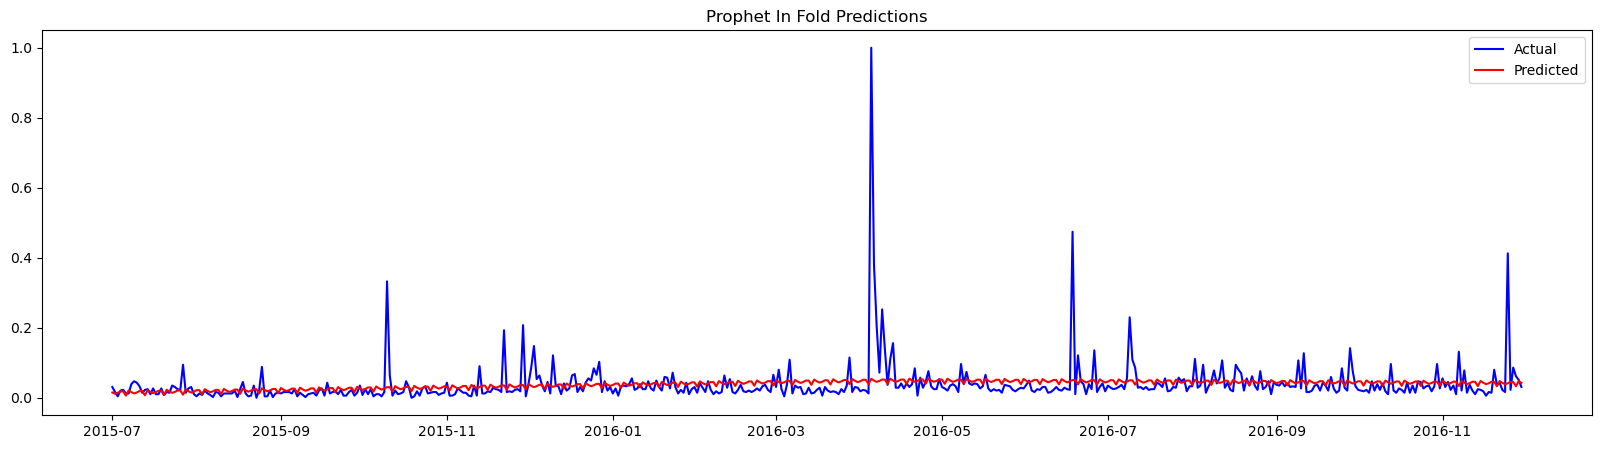

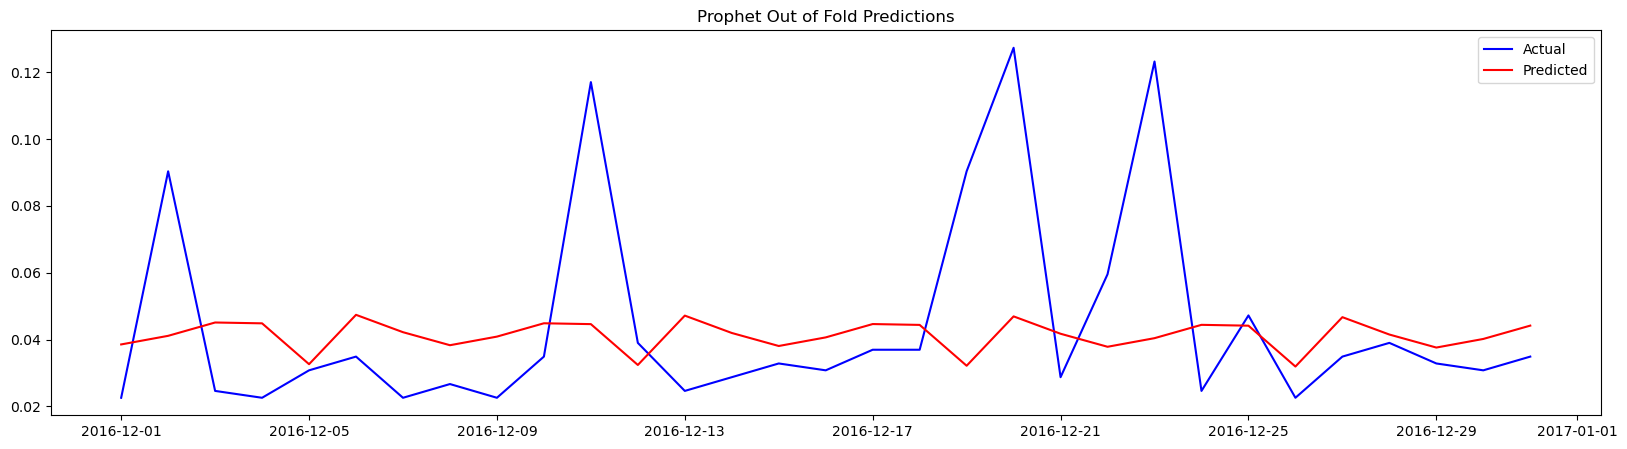

Train Error: 61.29821993919299 | Test Error: 42.62236955699422


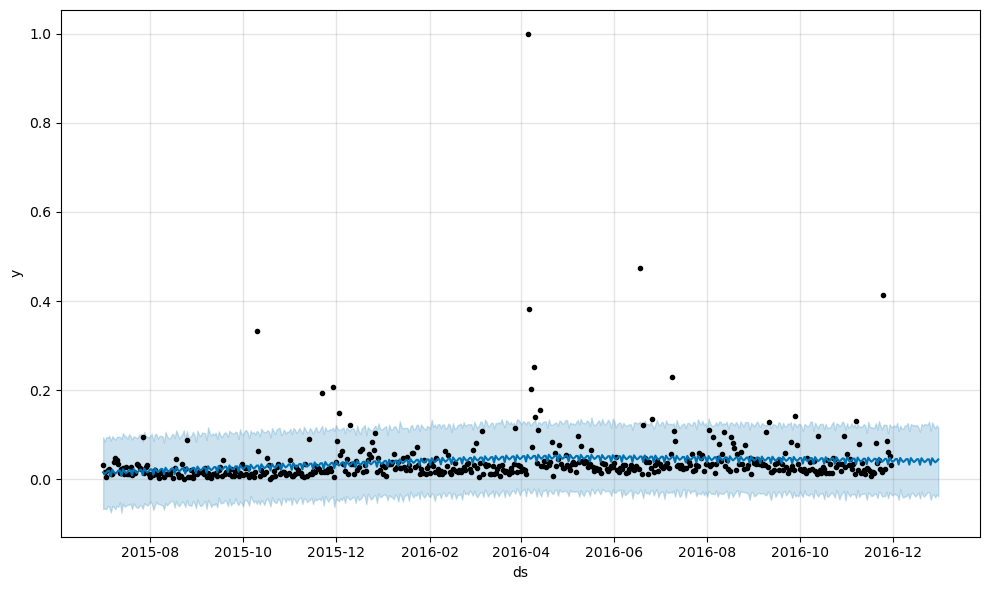

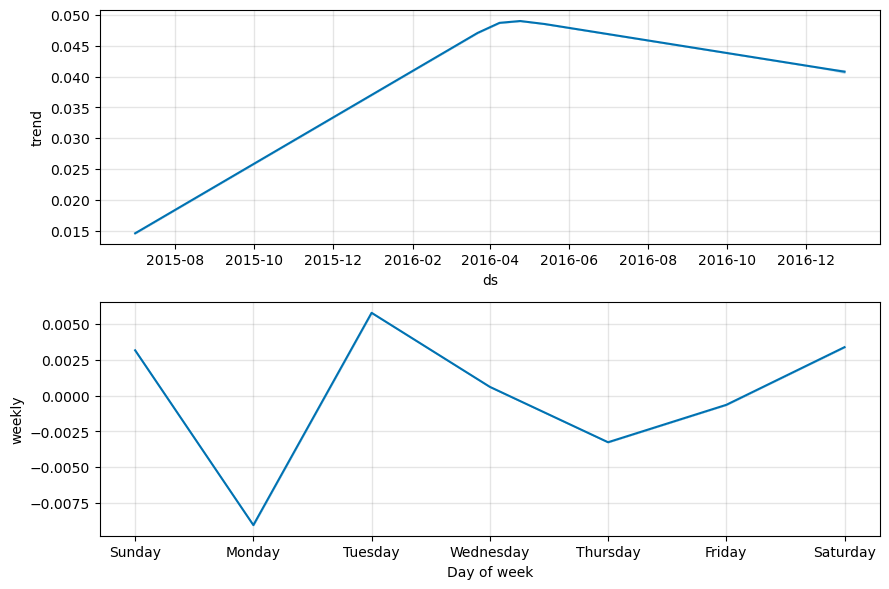

In [29]:
row_p = data.iloc[0, :]
model_prophet = prophet(row_p, 31, True, True)

## LSTM

In [30]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Sequential
from sklearn.metrics import mean_squared_error

In [31]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return np.array(dataX), np.array(dataY)

In [32]:
def Lstm(x_train, y_train, input_shape, num_lstm, epochs):
    
    model = Sequential()
    model.add(LSTM(num_lstm, input_shape=input_shape))
    model.add(Dense(1))
    
    model.compile(
        loss='mean_squared_error',
        optimizer='adam'
    )
    
    es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    
    model.fit(x_train, y_train, epochs=epochs, batch_size=1, verbose=0, callbacks=[es])
    
    return model

In [33]:
def run_lstm(data, num_lstm, epochs, visualize_predictions=False):

    # Scale the visits
    scaler = MinMaxScaler()
    scaled_row = scaler.fit_transform(np.array(data).reshape(-1, 1))
    
    # split into training and testing
    train_data = scaled_row[:-31]
    test_data = scaled_row[-31:]
    
    # Transform the dataset
    x_train, y_train = create_dataset(train_data.reshape(-1, 1))
    x_test, y_test = create_dataset(test_data.reshape(-1, 1))
    
    # Reshape the data for the lstm model
    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

    model = Lstm(x_train, y_train, (1, 1), num_lstm, epochs)

    # test the model
    train_pred = model.predict(x_train)
    test_pred = model.predict(x_test)
    
    train_pred_inverse = scaler.inverse_transform(train_pred)
    train_true_inverse = scaler.inverse_transform([y_train])
    test_pred_inverse = scaler.inverse_transform(test_pred)
    test_true_inverse = scaler.inverse_transform([y_test])
    
    if visualize_predictions:
        plot_predictions(y_train.reshape(-1, 1), train_pred, figsize=(20, 5), title='LSTM Training Predictions')
        plot_predictions(y_test.reshape(-1, 1), test_pred, figsize=(20, 5), title='LSTM Testing Predictions')
    
    # Error
    train_error_mae = mean_squared_error(y_train.reshape(-1, 1), train_pred)
    test_error_mae = mean_squared_error(y_test.reshape(-1, 1), test_pred)
    
    train_error_smape = smape(y_train, train_pred)
    test_error_smape = smape(y_test, test_pred)
    
    print('Mean Squared Error')
    print(f'Train Error: {train_error_mae} | Test Error: {test_error_mae}')
    print('-' * 100)
    print('SMAPE')
    print(f'Train Error: {train_error_smape} | Test Error: {test_error_smape}')
    
    return model

1/1 [==============================] - 0s 20ms/step


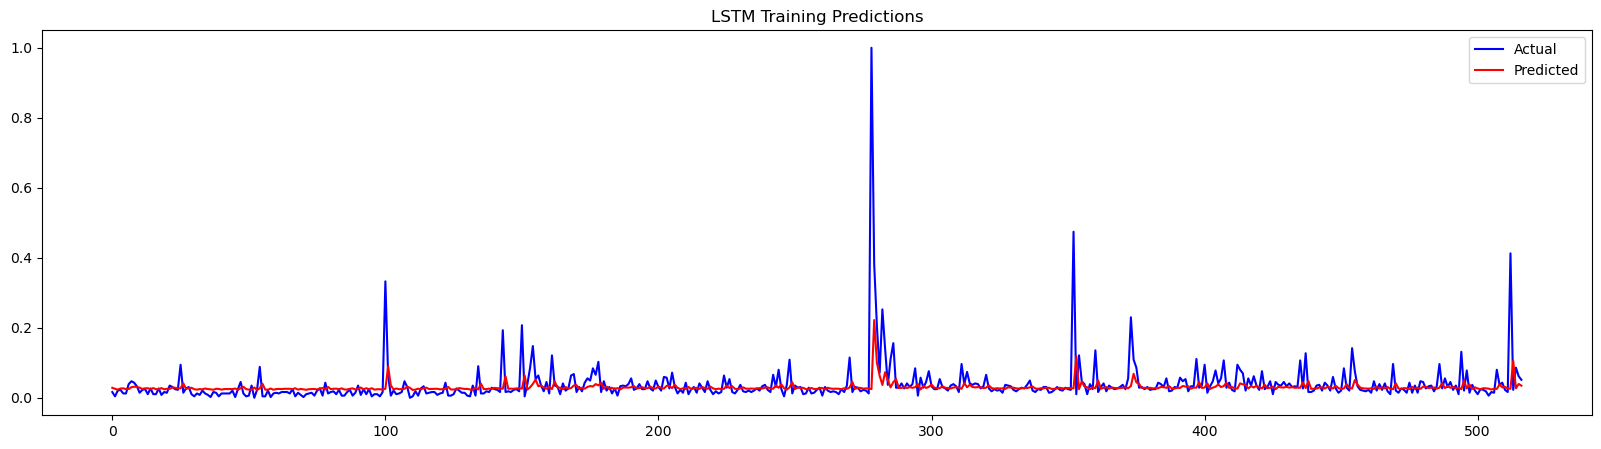

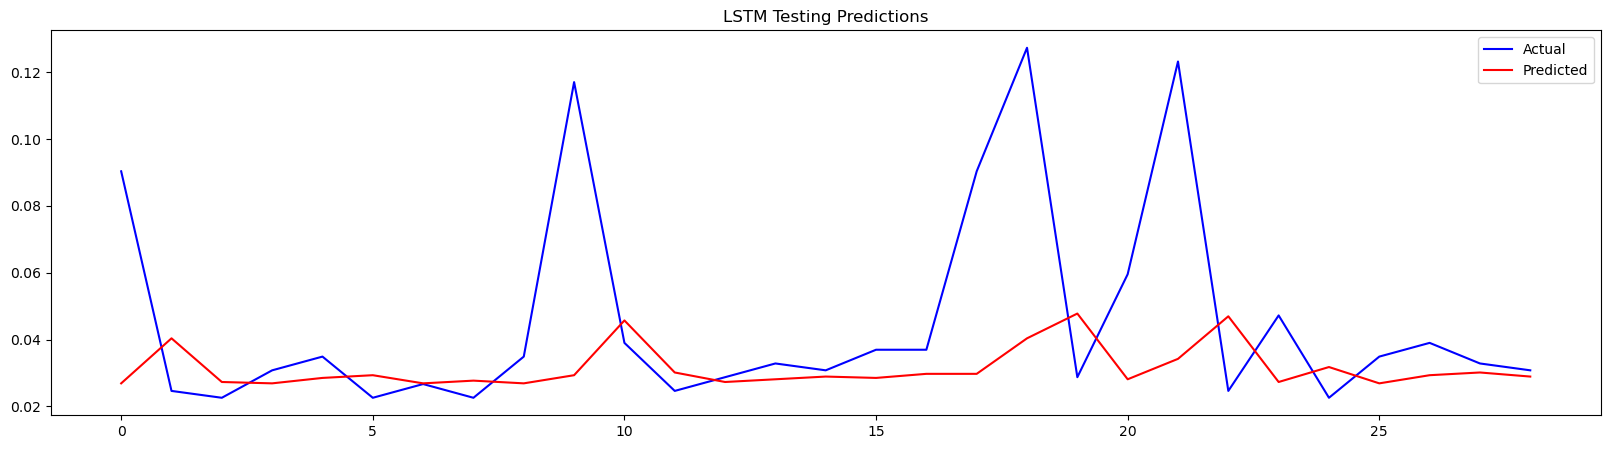

Mean Squared Error
Train Error: 0.003690076376344395 | Test Error: 0.0011741034357771842
----------------------------------------------------------------------------------------------------
SMAPE
Train Error: 29513.882341064542 | Test Error: 1118.158763783339


In [34]:
row = data.iloc[0, :]
model_lstm = run_lstm(row, 10, 10, True)

### XGBoost

In [35]:
from xgboost import XGBRegressor

In [36]:
def xgboost(data, estimators, visualize_predictions):
    
    # Split into training and testing
    train = row[:-31].values
    test = row[-31:].values
    
    x_train, y_train = create_dataset(train.reshape(-1, 1))
    x_test, y_test = create_dataset(test.reshape(-1, 1))
    
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(x_train, y_train)
    
    train_pred = model.predict(x_train)
    test_pred = model.predict(x_test)
    
    train_error = smape(y_train, train_pred)
    test_error = smape(y_test, test_pred)
    
    if visualize_predictions:
        plot_predictions(y_train, train_pred, figsize=(15, 4), title='Training Predictions')
        plot_predictions(y_test, test_pred, figsize=(15, 4), title='Testing Predictions')
    
    print(f'Train Error: {train_error} | Test Error: {test_error}')
    
    return model

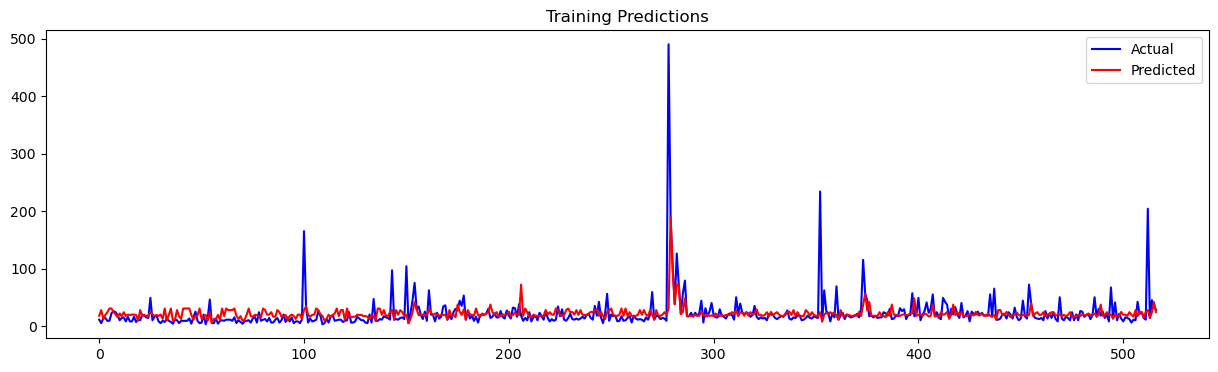

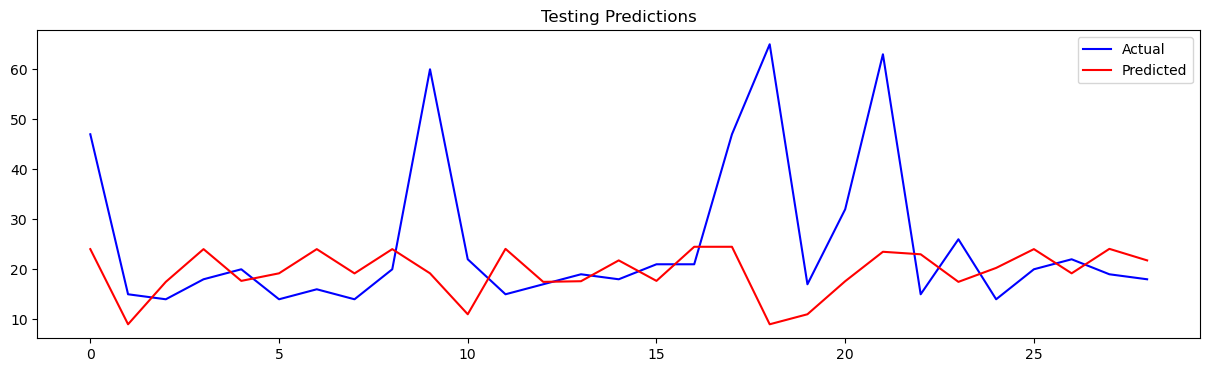

Train Error: 47.35977211665853 | Test Error: 40.541707515625895


In [37]:
row_xg = data.iloc[1, :]
model_xgb = xgboost(row_xg, 2000, True)

In [4]:
df = pd.read_csv('/kaggle/input/train1/train_1.csv')
data_start_date = df.columns[1]
data_end_date = df.columns[-1]


In [5]:
from datetime import timedelta

pred_steps = 60 
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1) 

In [6]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1) 

In [7]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [8]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

# convolutional operation parameters
n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2 

# define an input history series and pass it through a stack of dilated causal convolution blocks. 
history_seq = Input(shape=(None, 1))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)

# extract the last 60 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':60})(out)

model = Model(history_seq, pred_seq_train)
model.compile(Adam(), loss='mean_absolute_error')

In [9]:
first_n_samples = 120000
batch_size = 2**11
epochs = 10

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)  

Epoch 1/10
47/47 [==============================] - 94s 1s/step - loss: 0.3751 - val_loss: 0.2787
Epoch 2/10
47/47 [==============================] - 58s 1s/step - loss: 0.2938 - val_loss: 0.2617
Epoch 3/10
47/47 [==============================] - 58s 1s/step - loss: 0.2794 - val_loss: 0.2531
Epoch 4/10
47/47 [==============================] - 58s 1s/step - loss: 0.2734 - val_loss: 0.2506
Epoch 5/10
47/47 [==============================] - 58s 1s/step - loss: 0.2702 - val_loss: 0.2477
Epoch 6/10
47/47 [==============================] - 58s 1s/step - loss: 0.2686 - val_loss: 0.2473
Epoch 7/10
47/47 [==============================] - 58s 1s/step - loss: 0.2673 - val_loss: 0.2457
Epoch 8/10
47/47 [==============================] - 58s 1s/step - loss: 0.2664 - val_loss: 0.2459
Epoch 9/10
47/47 [==============================] - 58s 1s/step - loss: 0.2655 - val_loss: 0.2433
Epoch 10/10
47/47 [==============================] - 58s 1s/step - loss: 0.2644 - val_loss: 0.2428


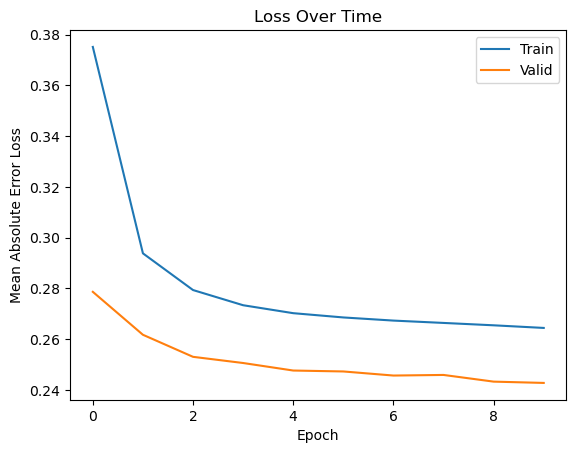

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [11]:
def predict_sequence(input_sequence):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence

In [12]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [13]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = predict_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

1/1 [==============================] - 0s 53ms/step


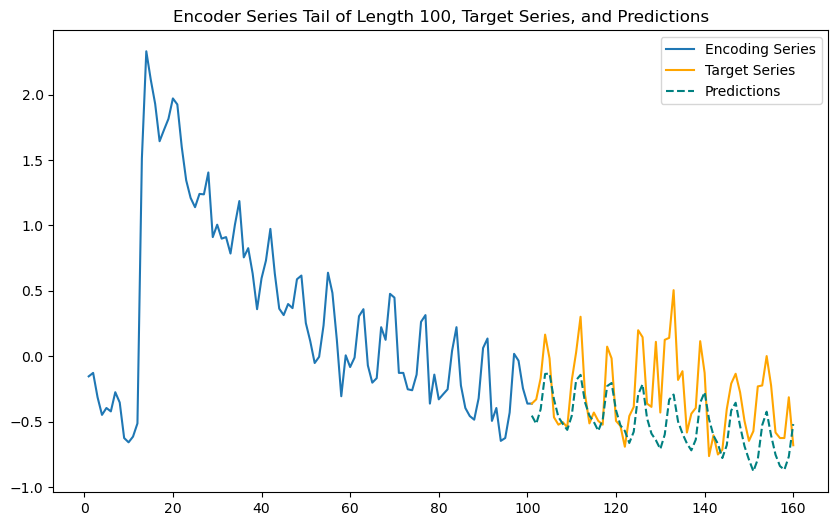

In [14]:
predict_and_plot(encoder_input_data, decoder_target_data,sample_ind=16534, enc_tail_len=100)

1/1 [==============================] - 0s 24ms/step


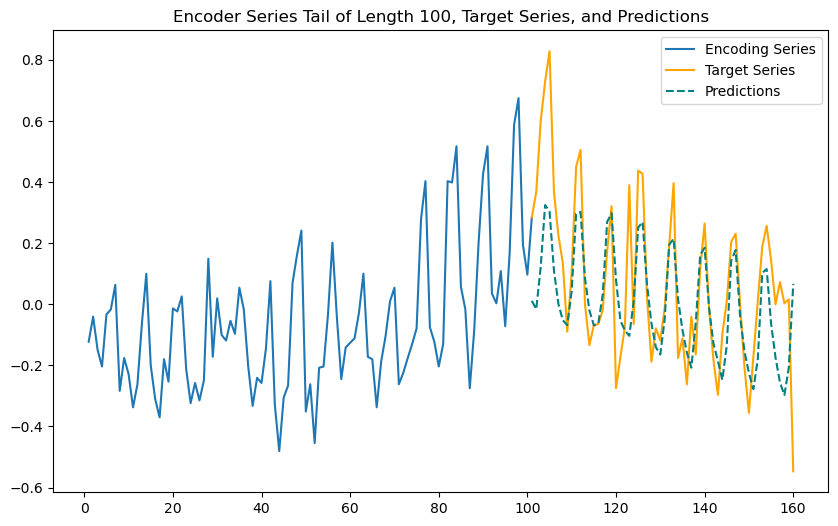

In [15]:
predict_and_plot(encoder_input_data, decoder_target_data,sample_ind=16555, enc_tail_len=100)